# Regression

In [10]:
import warnings
warnings.filterwarnings("ignore")
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    r2_score,
)

RANDOM_STATE = 42


**Airbnb Prices in European Cities**
Задача: по информации о квартирепредсказать общую стоимость проживания для двух человек на две ночи в евро.

Практический смысл: предсказывать цены аренды и помогать хостам выставлять адекватный прайс

Метрики: 

Data Dictionary
- realSum	The total price of the Airbnb listing. (Numeric)
- room_type	The type of room being offered (e.g. private, shared, etc.). (Categorical)
- room_shared	Whether the room is shared or not. (Boolean)
- room_private	Whether the room is private or not. (Boolean)
- person_capacity	The maximum number of people that can stay in the room. (Numeric)
- host_is_superhost	Whether the host is a superhost or not. (Boolean)
- multi	Whether the listing is for multiple rooms or not. (Boolean)
- biz	Whether the listing is for business purposes or not. (Boolean)
- cleanliness_rating	The cleanliness rating of the listing. (Numeric)
- guest_satisfaction_overall	The overall guest satisfaction rating of the listing. (Numeric)
- bedrooms	The number of bedrooms in the listing. (Numeric)
- dist	The distance from the city centre. (Numeric)
- metro_dist	The distance from the nearest metro station. (Numeric)
- lng	The longitude of the listing. (Numeric)
- lat	The latitude of the listing. (Numeric)

In [11]:
cities=['amsterdam','athens','barcelona','berlin','budapest','lisbon','london','paris','rome','vienna']
weekend_data={}
weekdays_data={}
base_path = "data/regression/airbnb_prices"

for city in cities:
    # Weekday file
    weekday_filename = f"{city}_weekdays.csv"
    weekday_path = os.path.join(base_path, weekday_filename)
    weekdays_data[city] = pd.read_csv(weekday_path,index_col=0)

    # Weekend file
    weekend_filename = f"{city}_weekends.csv"
    weekend_path = os.path.join(base_path, weekend_filename)
    weekend_data[city] = pd.read_csv(weekend_path,index_col=0)

#loading multiple data in two dictioneries with key is the name of city
#___________________________________________________________________________________________________________________________________________________
#now combining the two dictionaries in one dataset for analyzing it 
all_data = []

for city in cities:
    if city in weekdays_data:
        # Adding weekday data
        weekday_df = weekdays_data[city].copy()
        weekday_df['city'] = city.title()
        weekday_df['day_type'] = 'weekday'
        all_data.append(weekday_df)
        
        # Adding weekend data
        weekend_df = weekend_data[city].copy()
        weekend_df['city'] = city.title()
        weekend_df['day_type'] = 'weekend'
        all_data.append(weekend_df)

# Combinining all data
df = pd.concat(all_data)
df.shape

(51707, 21)

In [12]:
df.head()

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,dist,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,city,day_type
0,194.033698,Private room,False,True,2.0,False,1,0,10.0,93.0,...,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,4.90569,52.41772,Amsterdam,weekday
1,344.245776,Private room,False,True,4.0,False,0,0,8.0,85.0,...,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,4.90005,52.37432,Amsterdam,weekday
2,264.101422,Private room,False,True,2.0,False,0,1,9.0,87.0,...,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,4.97512,52.36103,Amsterdam,weekday
3,433.529398,Private room,False,True,4.0,False,0,1,9.0,90.0,...,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,4.89417,52.37663,Amsterdam,weekday
4,485.552926,Private room,False,True,2.0,True,0,0,10.0,98.0,...,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,4.90051,52.37508,Amsterdam,weekday


In [13]:
# пропуски
df.isna().mean().sort_values(ascending=False)

realSum                       0.0
dist                          0.0
city                          0.0
lat                           0.0
lng                           0.0
rest_index_norm               0.0
rest_index                    0.0
attr_index_norm               0.0
attr_index                    0.0
metro_dist                    0.0
bedrooms                      0.0
room_type                     0.0
guest_satisfaction_overall    0.0
cleanliness_rating            0.0
biz                           0.0
multi                         0.0
host_is_superhost             0.0
person_capacity               0.0
room_private                  0.0
room_shared                   0.0
day_type                      0.0
dtype: float64

In [14]:
# Целевая переменная: общая стоимость проживания
target_col = "realSum"

# Разделим признаки и цель
X = df.drop(columns=[target_col])
y = df[target_col]

# Разделение на train / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE
)

# Определяем типы признаков
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object", "bool"]).columns.tolist()

num_cols, cat_cols


(['person_capacity',
  'multi',
  'biz',
  'cleanliness_rating',
  'guest_satisfaction_overall',
  'bedrooms',
  'dist',
  'metro_dist',
  'attr_index',
  'attr_index_norm',
  'rest_index',
  'rest_index_norm',
  'lng',
  'lat'],
 ['room_type',
  'room_shared',
  'room_private',
  'host_is_superhost',
  'city',
  'day_type'])

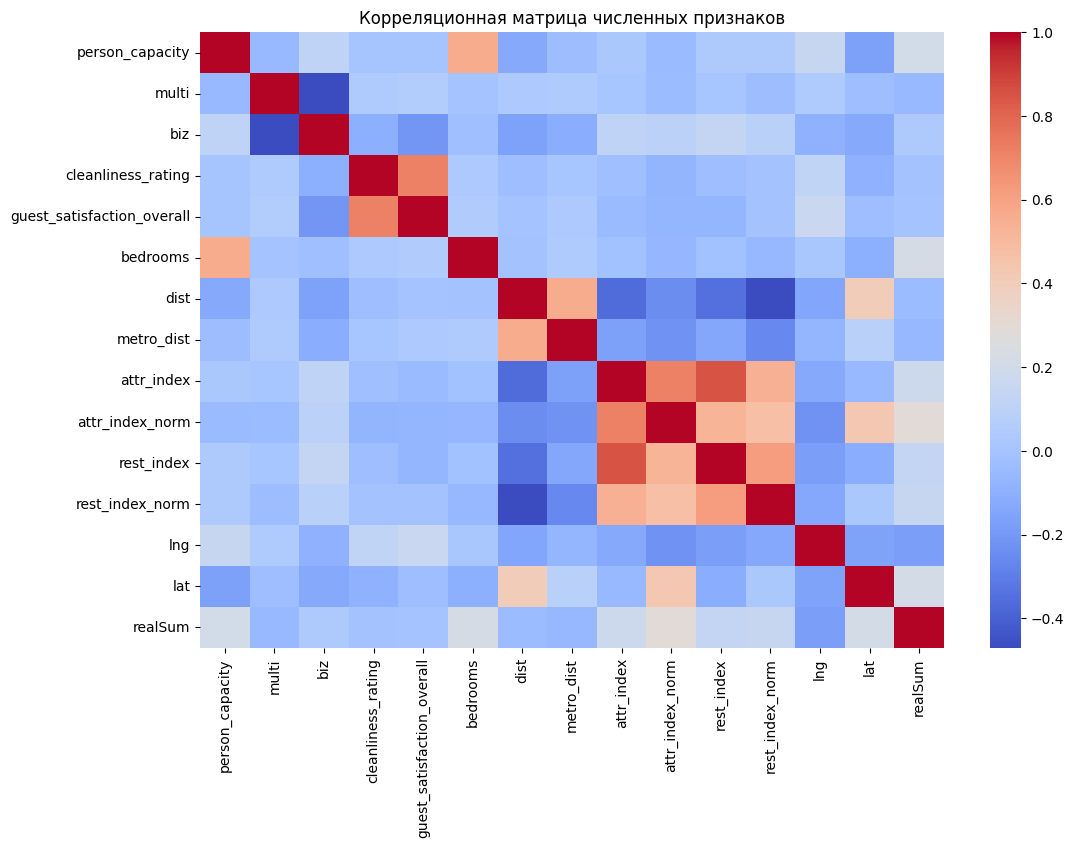

realSum                       1.000000
attr_index_norm               0.292396
bedrooms                      0.221653
lat                           0.211805
person_capacity               0.203077
attr_index                    0.178228
rest_index_norm               0.144094
rest_index                    0.134722
biz                           0.037144
guest_satisfaction_overall   -0.001888
cleanliness_rating           -0.006082
dist                         -0.044725
multi                        -0.052926
metro_dist                   -0.061025
lng                          -0.173833
Name: realSum, dtype: float64

In [15]:
num_cols_corr = num_cols + ["realSum"]
corr = df[num_cols_corr].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(
    corr,
    annot=False,
    cmap="coolwarm",
)
plt.title("Корреляционная матрица численных признаков")
plt.show()

corr["realSum"].sort_values(ascending=False)


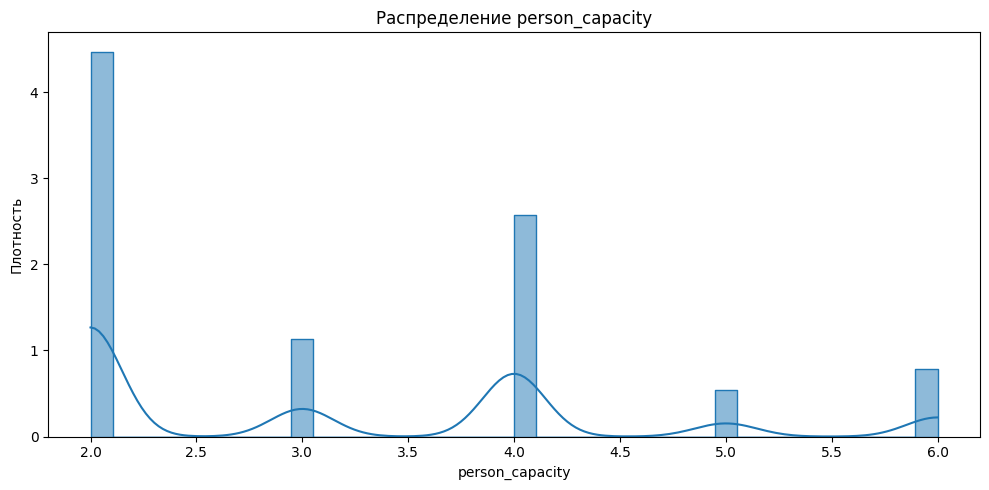

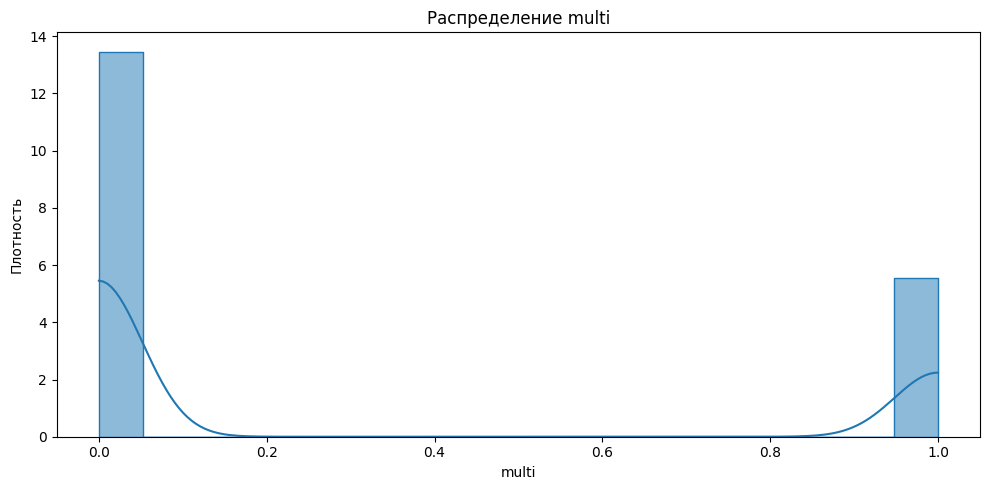

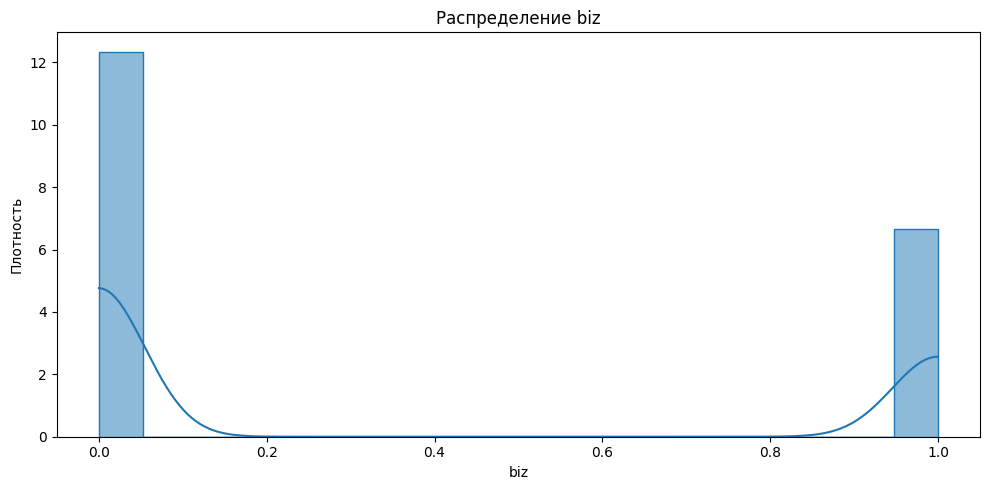

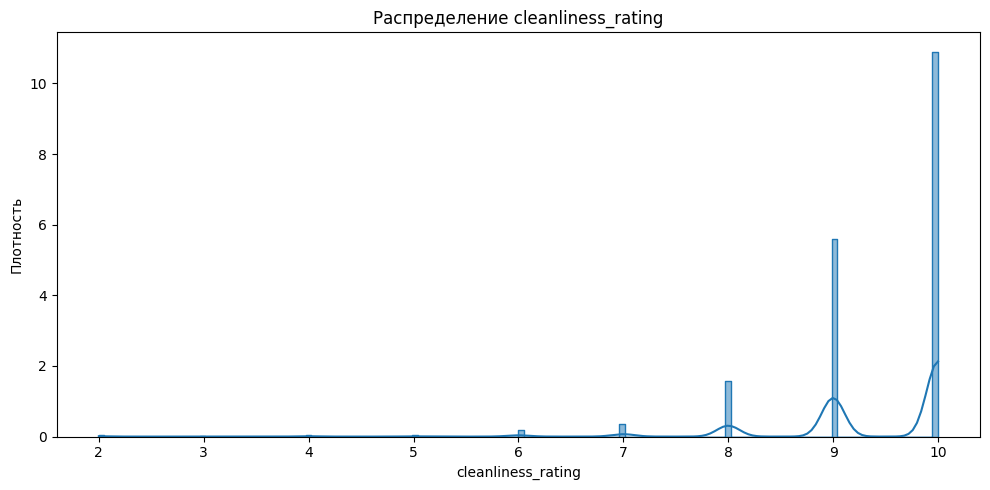

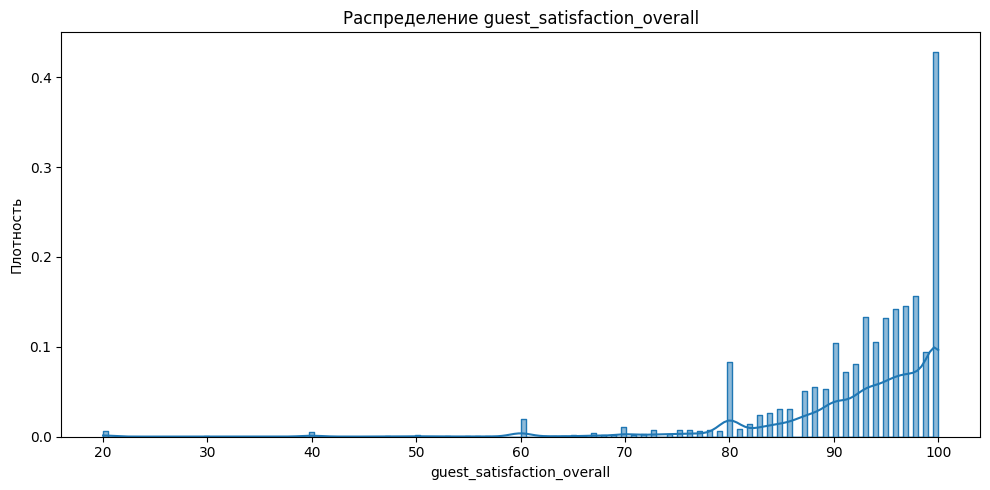

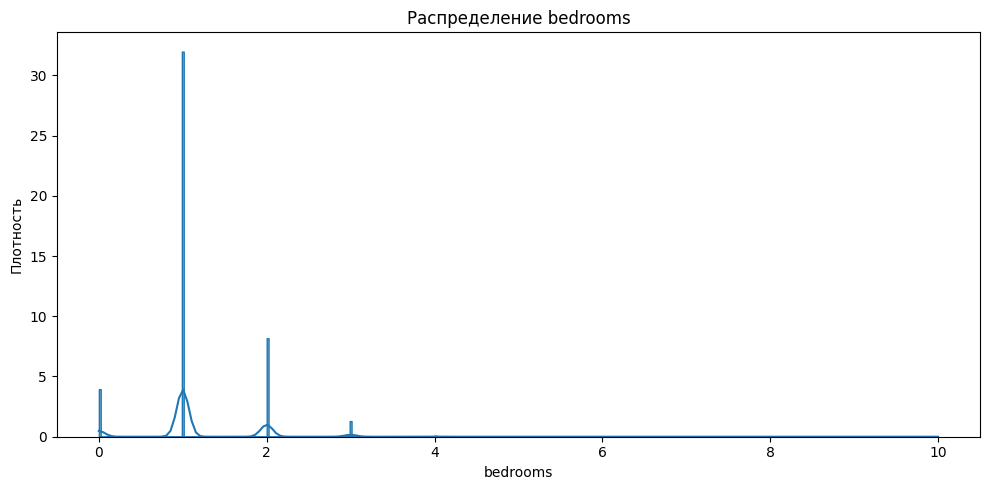

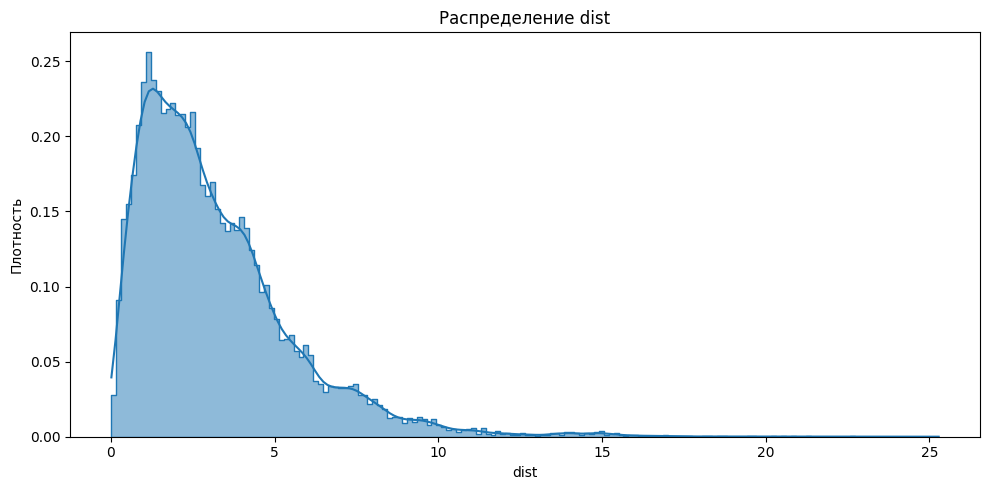

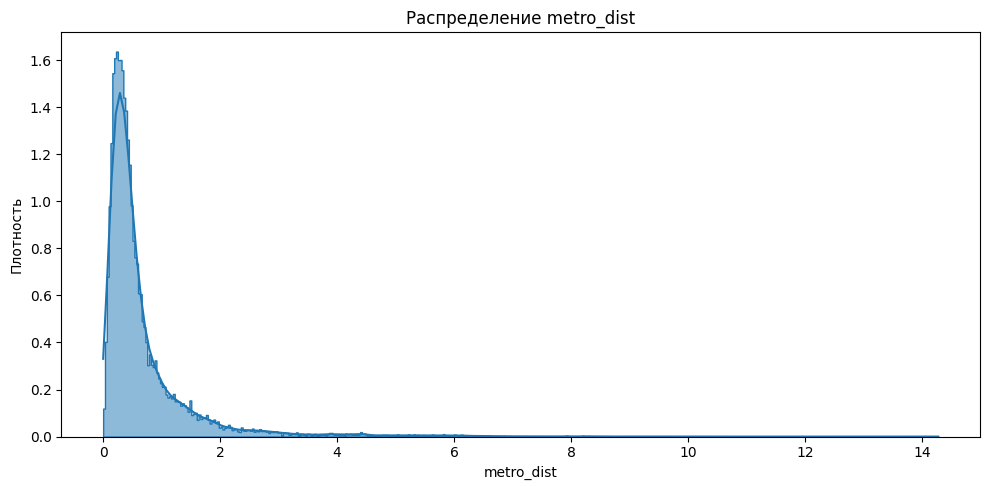

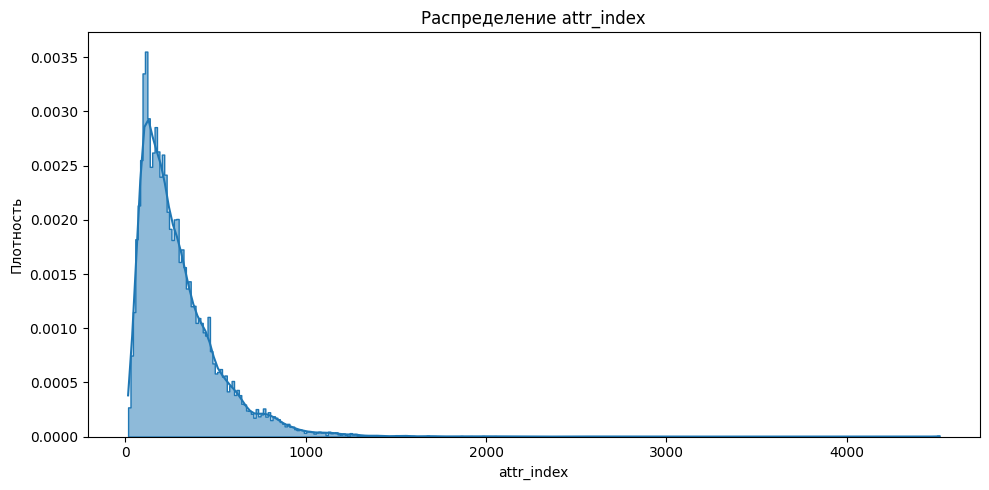

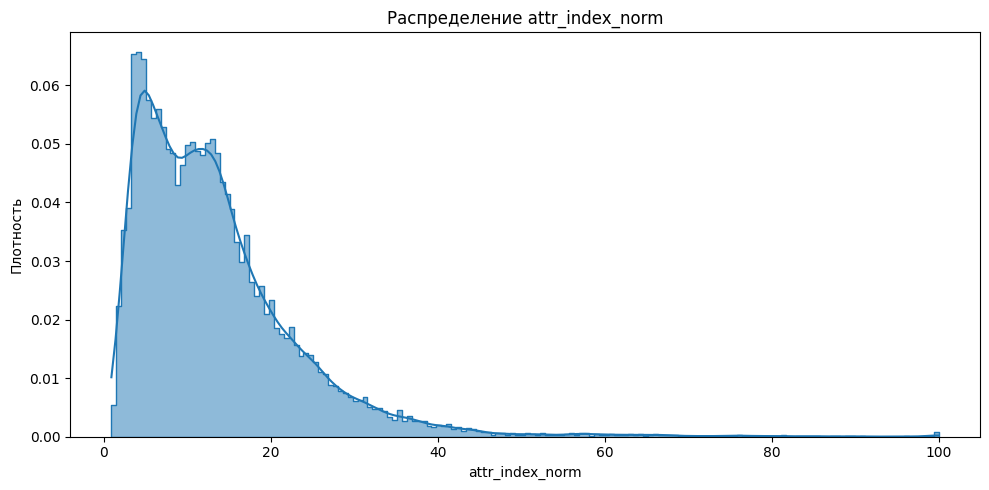

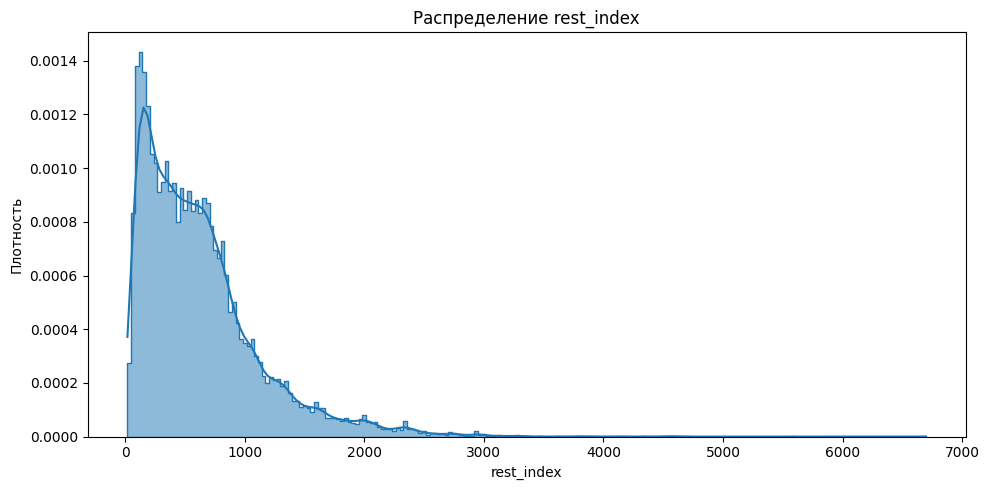

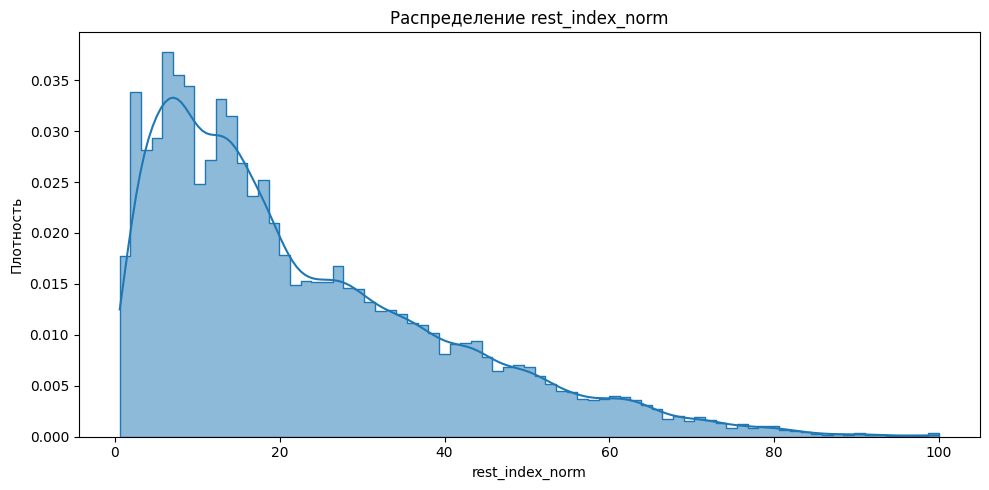

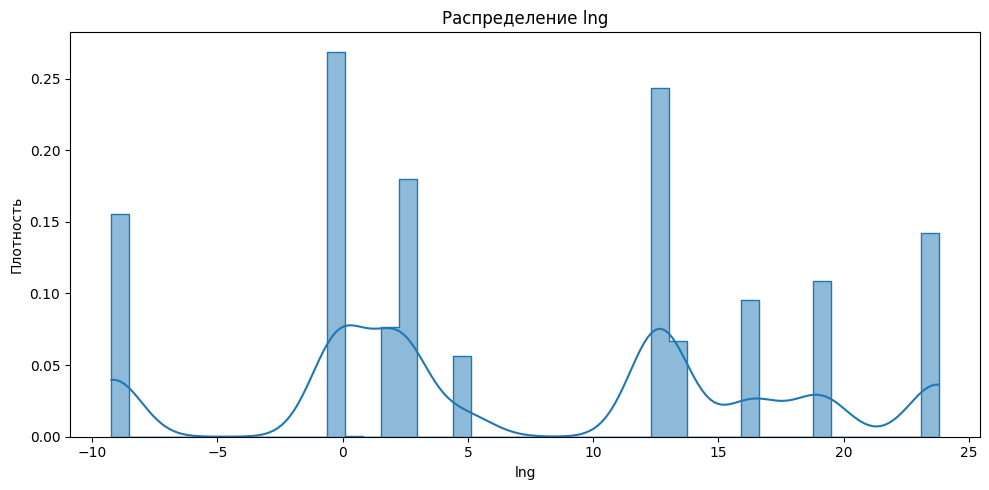

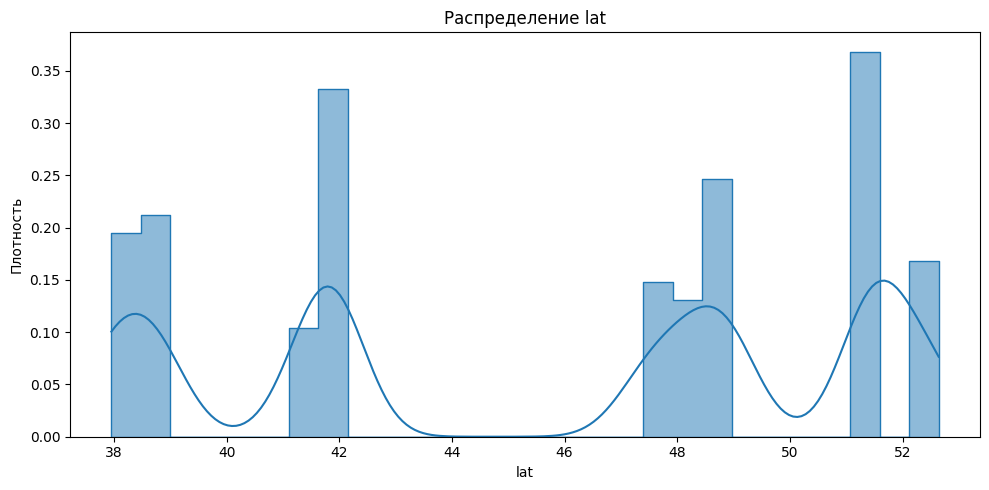

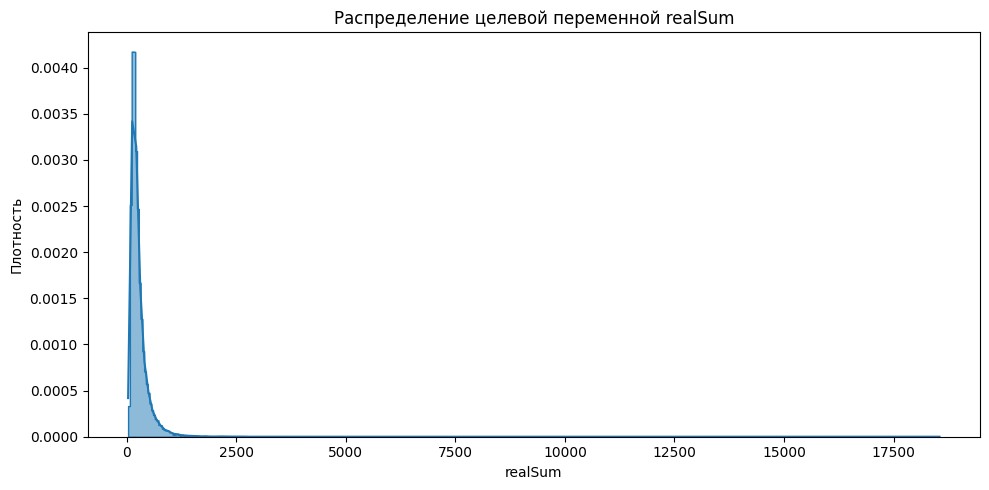

In [16]:
for col in num_cols:
    plt.figure(figsize=(10, 5))
    sns.histplot(
        data=df,
        x=col,
        kde=True,
        element="step",
        stat="density",
    )
    plt.title(f"Распределение {col}")
    plt.xlabel(col)
    plt.ylabel("Плотность")
    plt.tight_layout()
    plt.show()

plt.figure(figsize=(10, 5))
sns.histplot(df["realSum"], kde=True, element="step", stat="density")
plt.title("Распределение целевой переменной realSum")
plt.xlabel("realSum")
plt.ylabel("Плотность")
plt.tight_layout()
plt.show()


## Sklearn Model

In [17]:
numeric_transformer = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

gb_reg_baseline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("regressor", GradientBoostingRegressor(random_state=RANDOM_STATE))
])

gb_reg_baseline.fit(X_train, y_train)

y_pred_baseline = gb_reg_baseline.predict(X_test)


In [18]:
mse_baseline = mean_squared_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
r2_baseline = r2_score(y_test, y_pred_baseline)

print("=== Gradient Boosting Regressor — baseline ===")
print(f"RMSE: {rmse_baseline:.2f}")
print(f"MAE: {mae_baseline:.2f}")
print(f"R2: {r2_baseline:.4f}")


=== Gradient Boosting Regressor — baseline ===
RMSE: 270.22
MAE: 78.96
R2: 0.3524


### Улучшим бейзлайн

In [19]:
def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    # Вместимость относительно числа комнат
    bedrooms_safe = df["bedrooms"].replace(0, np.nan)
    df["capacity_per_bedroom"] = df["person_capacity"] / bedrooms_safe
    df["capacity_per_bedroom"] = df["capacity_per_bedroom"].fillna(df["person_capacity"])

    # Центральность и транспортная доступность
    df["centrality_score"] = 1 / (df["dist"] + 1e-3)
    df["metro_proximity"] = 1 / (df["metro_dist"] + 1e-3)
    df["attraction_density"] = df["attr_index_norm"] + df["rest_index_norm"]

    # Комфорт проживания
    df["comfort_score"] = (
        df["cleanliness_rating"].fillna(df["cleanliness_rating"].median())
        + df["guest_satisfaction_overall"].fillna(df["guest_satisfaction_overall"].median())
    )

    # Выходные дни
    df["is_weekend"] = (df["day_type"] == "weekend").astype(int)

    return df


In [21]:
# 1. Добавляем фичи к исходному df
df_fe = add_features(df)

# 2. Формируем X и y заново — без целевой переменной
feature_cols = [c for c in df_fe.columns if c not in ["realSum"]]
X_fe = df_fe[feature_cols]
y_fe = df_fe["realSum"]

# 3. Делаем новый train/test split
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_fe, y_fe, test_size=0.2, random_state=RANDOM_STATE
)

# 4. Пересчитываем списки числовых и категориальных колонок
num_cols_fe = X_fe.select_dtypes(include=["int64", "float64"]).columns.tolist()
cat_cols_fe = X_fe.select_dtypes(include=["object", "bool"]).columns.tolist()

# 5. Делаем НОВЫЙ preprocessor под расширенный набор фичей
numeric_transformer_fe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_transformer_fe = Pipeline(steps=[
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor_fe = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer_fe, num_cols_fe),
        ("cat", categorical_transformer_fe, cat_cols_fe)
    ]
)

# 6. Pipeline для тюнинга
gb_reg_tuned = Pipeline(steps=[
    ("preprocess", preprocessor_fe),
    ("regressor", GradientBoostingRegressor(random_state=RANDOM_STATE))
])

# 7. GridSearch по новым данным
param_grid_reg = {
    "regressor__n_estimators": [200, 300],
    "regressor__learning_rate": [0.05, 0.1, 0.15],
    "regressor__max_depth": [3, 5, 8],
}

cv = KFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

grid_reg = GridSearchCV(
    gb_reg_tuned,
    param_grid_reg,
    cv=cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_reg.fit(X_train_fe, y_train_fe)

print("Лучшие параметры (Gradient Boosting Regressor):")
print(grid_reg.best_params_)
print("Лучший MAE на кросс-валидации:", -grid_reg.best_score_)

best_reg = grid_reg.best_estimator_

# 8. Оценка на тесте
y_pred_best = best_reg.predict(X_test_fe)

mse_best = mean_squared_error(y_test_fe, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test_fe, y_pred_best)
r2_best = r2_score(y_test_fe, y_pred_best)

print("=== Gradient Boosting — улучшенный бейзлайн (с новыми фичами) ===")
print(f"RMSE: {rmse_best:.2f}")
print(f"MAE: {mae_best:.2f}")
print(f"R2: {r2_best:.4f}")


Fitting 3 folds for each of 18 candidates, totalling 54 fits
Лучшие параметры (Gradient Boosting Regressor):
{'regressor__learning_rate': 0.15, 'regressor__max_depth': 8, 'regressor__n_estimators': 300}
Лучший MAE на кросс-валидации: 64.59327026355102
=== Gradient Boosting — улучшенный бейзлайн (с новыми фичами) ===
RMSE: 189.93
MAE: 59.61
R2: 0.6801


### Сравнение бейзлайна и улучшенного бейзлайна (Gradient Boosting Regressor)

- Бейзлайн: исходные признаки + стандартная предобработка, метрики RMSE/MAE/R2.
- Улучшенный бейзлайн: добавлены инженерные признаки (centrality_score, capacity_per_bedroom, comfort_score и др.) + подбор гиперпараметров.
- Сравнивать по напечатанным метрикам: уменьшение RMSE/MAE и рост R2 означают улучшение.


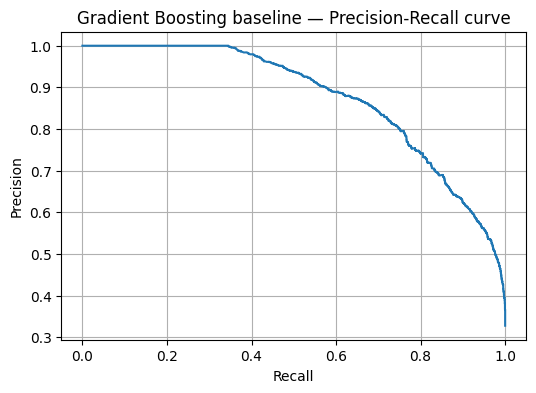

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_baseline, alpha=0.4)
lims = [min(y_test.min(), y_pred_baseline.min()), max(y_test.max(), y_pred_baseline.max())]
plt.plot(lims, lims, color="red", linestyle="--")
plt.xlabel("Факт realSum")
plt.ylabel("Предсказание realSum")
plt.title("Gradient Boosting baseline — факт vs предсказание")
plt.grid(True)
plt.tight_layout()
plt.show()


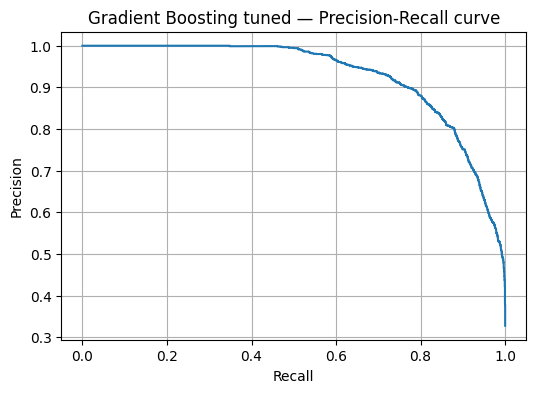

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test_fe, y_pred_best, alpha=0.4, color="tab:orange")
lims = [min(y_test_fe.min(), y_pred_best.min()), max(y_test_fe.max(), y_pred_best.max())]
plt.plot(lims, lims, color="red", linestyle="--")
plt.xlabel("Факт realSum")
plt.ylabel("Предсказание realSum")
plt.title("Gradient Boosting tuned — факт vs предсказание")
plt.grid(True)
plt.tight_layout()
plt.show()
